In [2]:
import os
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np

## Data Collection via Webcam

In [2]:
path = './data'

if not os.path.exists(path):
    os.makedirs(path)         # Creating a data folder

n_class = 3    # number of class (hand sign)
n_images = 50    # number of image in each class

cap = cv2.VideoCapture(0)

for j in range(n_class):
    
    if not os.path.exists(os.path.join(path, str(j))):
        os.makedirs(os.path.join(path, str(j)))   # Example:  .\data\1 (directory)

    print('Collecting images for class {}'.format(j))
    
   
    while True:   
        bol, frame = cap.read()    # This reads a frame from the video capture.
        cv2.putText(frame, 'Press "S" to capture images', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.imshow('webcam', frame)
        
        if cv2.waitKey(25) == ord('s'):
            break        # Press S when ready to capture and break the while loop

    
    for i in range(n_images):
        bol, frame = cap.read()       
        cv2.imshow('webcam', frame) 
        cv2.waitKey(25)    
        cv2.imwrite(os.path.join(path, str(j), '{}.jpg'.format(i)), frame)
        
        # This saves the current frame to a file in the appropriate subdirectory for the current class. 
        # The image file will be named {class_number}.jpg and will be saved in the path under the corresponding class subdirectory.
    

cap.release()
cv2.destroyAllWindows()

## Data Processing

Preprocessing with single image

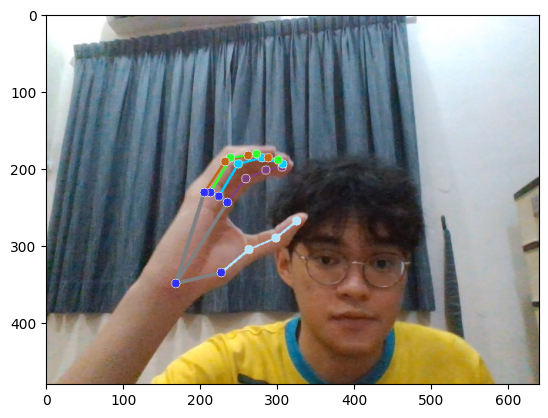

In [3]:
image_path = './data/2/24.jpg'
image = cv2.imread(image_path)


# Convert BGR to RGB for better interoperability with various image processing libraries and frameworks that expect RGB images
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


mp_hands = mp.solutions.hands   # responsible for hand tracking

# For visualization

mp_drawing = mp.solutions.drawing_utils    # provides utility functions for rendering landmarks, connections, and other annotations on the images.
mp_drawing_styles = mp.solutions.drawing_styles   # defines different drawing styles for landmarks and connections, such as color, line thickness, and circle radius.

hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

result = hands.process(image_rgb)

if result.multi_hand_landmarks:            # if hand is detected in the image
    for hand_landmarks in result.multi_hand_landmarks: 
        
        mp_drawing.draw_landmarks(
            image_rgb, # image to draw on
            hand_landmarks,
            mp_hands.HAND_CONNECTIONS, #hand connections
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style()   
            )
        
        
plt.figure()
plt.imshow(image_rgb)

In [4]:
print(hand_landmarks.landmark[:5])  # First five landmark points

[x: 0.2637646198272705
y: 0.7290914058685303
z: 4.114303067126457e-07
, x: 0.3551921844482422
y: 0.699669361114502
z: 0.03706599771976471
, x: 0.412018358707428
y: 0.6372014284133911
z: 0.05682941898703575
, x: 0.4660567045211792
y: 0.6053522825241089
z: 0.05925697460770607
, x: 0.508590817451477
y: 0.5602115988731384
z: 0.06057390570640564
]


Each hand_landmarks variable is a list of landmark points, and each landmark point is represented as a 3D vector (x, y, z). The (x, y) coordinates represent the position of the landmark normalized to the image dimensions (ranging from 0 to 1, where (0,0) is the top-left corner and (1,1) is the bottom-right corner). The z-coordinate represents the depth or distance of the landmark from the camera plane.

We will utilize the coordinates for model training.

## Processing jpg files in batch

In [3]:
# hand-tracking module
mp_hands = mp.solutions.hands  

#  initializes the hand tracking process.
hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

path = './data'

data = []
labels = []


for dir_ in os.listdir(path):
    for img_path in os.listdir(os.path.join(path, dir_)):   # example './data/1/1.jpg'
        
        lst = []
        x_ = []
        y_ = []
    
        img = cv2.imread(os.path.join(path, dir_, img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

        results = hands.process(img_rgb)
        
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                
                for i in range(len(hand_landmarks.landmark)):
                    x = hand_landmarks.landmark[i].x            # Extract x and y coordinates
                    y = hand_landmarks.landmark[i].y
                    
                    x_.append(x)
                    y_.append(y)

            x_min = np.min(x_)
            x_max = np.max(x_)
            y_min = np.min(y_)
            y_max = np.max(y_)
            
            # Normalize the landmarks by performing min-max normalization on both x and y coordinates
            
            lst = np.array([(x_ - x_min) / (x_max - x_min), (y_ - y_min) / (y_max - y_min)]).flatten()
                    
            data.append(lst)
            labels.append(dir_)

# convert to numpy
data_np = np.asarray(data)  # landmark points
labels_np = np.asarray(labels)  # class label

print(data_np.shape)
print(labels_np.shape)

(150, 42)
(150,)


The code checks if an image has any hand landmarks, which are 21 points that represent the position and orientation of the hand. If yes, it loops through each hand landmark and extracts its x and y coordinates. It appends these coordinates to a data_aux list, which contains 42 values (21 x and 21 y) for each hand.

* The data_np array has a shape of (n, 42), where n is the number of images processed. 

* The labels_np array has a shape of (n,), where n is the number of images processed.

## Model Training

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [5]:
# Simple Random Forest Model


x_train, x_test, y_train, y_test = train_test_split(data_np, labels_np, test_size=0.2, shuffle=True, stratify=labels)

model = RandomForestClassifier()

model.fit(x_train, y_train)

y_predict = model.predict(x_test)

score = accuracy_score(y_predict, y_test)

print('{}% of samples were classified correctly'.format(score * 100))

100.0% of samples were classified correctly


##  Test Detector

In [6]:


# hand-tracking module
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# Initialize the webcam
cam = cv2.VideoCapture(0)

# Initialize the hand tracking process.
hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

labels_dict = {0: 'A', 1: 'B', 2: 'C'}

while True:
    lst = []
    x_lst = []
    y_lst = []

    ret, frame = cam.read()

    H, W, _ = frame.shape

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    results = hands.process(frame_rgb)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
           
            # To visualize the coordinates on the cam
            mp_drawing.draw_landmarks(
                frame,  
                hand_landmarks,  
                mp_hands.HAND_CONNECTIONS,  
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style())

        for hand_landmarks in results.multi_hand_landmarks:
            for i in range(len(hand_landmarks.landmark)):
                x = hand_landmarks.landmark[i].x
                y = hand_landmarks.landmark[i].y

                x_lst.append(x)
                y_lst.append(y)
                
                
        x_min = np.min(x_lst)
        x_max = np.max(x_lst)
        y_min = np.min(y_lst)
        y_max = np.max(y_lst)
        
        # Normalize the landmarks by performing min-max normalization on both x and y coordinates
            
        lst = np.array([(x_lst - x_min) / (x_max - x_min), (y_lst - y_min) / (y_max - y_min)]).flatten() # For Prediction
            
        
        x1 = int(min(x_lst) * W) - 10
        y1 = int(min(y_lst) * H) - 10

        x2 = int(max(x_lst) * W) - 10
        y2 = int(max(y_lst) * H) - 10

       
        prediction = model.predict([np.asarray(lst)])
        predicted_character = "Output: " + labels_dict[int(prediction[0])] # Access dictionary

        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 0), 4)  # Tracking the hand movement
        cv2.putText(frame, predicted_character, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 0, 0), 3, cv2.LINE_AA)

   
    cv2.putText(frame, "Press 'X' to exit webcam", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    cv2.imshow('webcam', frame)

    key = cv2.waitKey(1) & 0xFF  

    if key == ord('x') or key == ord('X'):
        break

# Release the webcam and close the window
cam.release()
cv2.destroyAllWindows()
